In [ ]:
!pip install geopandas rioxarray netCDF4 xarray pyogrio --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 47.9 MB/s eta 0:00:00


In [ ]:
import os
import zipfile
import geopandas as gpd
import xarray as xr
import rioxarray
import pandas as pd
from shapely.geometry import mapping
from shapely.affinity import scale
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
# Загрузка и чтение geojson масок
mask_files = {
    "Barents Sea": "barents_sea.geojson",
    "Kara Sea": "kara_sea.geojson",
    "Chukchi Sea": "chukchi_sea.geojson",
    "Laptev Sea": "laptev_sea.geojson",
    "East Siberian Sea": "east_siberian_sea.geojson"
}

masks = {
    name: gpd.read_file(path) for name, path in mask_files.items()
}

In [ ]:
# Названия файлов и регионов
mask_files = {
    "Barents Sea": "barents_sea.geojson",
    "Kara Sea": "kara_sea.geojson",
    "Chukchi Sea": "chukchi_sea.geojson",
    "Laptev Sea": "laptev_sea.geojson",
    "East Siberian Sea": "east_siberian_sea.geojson"
}

# Проекция .nc файла
nc_proj = "+proj=laea +lat_0=90 +lon_0=0 +datum=WGS84"

In [ ]:
# Подготовка директорий для данных .nc

raw_data_dir = "/content/nc_archives"  # Папка с архивами
work_dir = "/content/extracted_nc"     # Папка для распаковки
os.makedirs(work_dir, exist_ok=True)

In [ ]:
# Шаг 1: Загрузка и трансформация масок
masks = {}
for name, path in mask_files.items():
    gdf = gpd.read_file(path).to_crs(nc_proj)
    gdf["geometry"] = gdf.geometry.apply(lambda geom: scale(geom, xfact=1/1000, yfact=1/1000, origin=(0, 0)))
    masks[name] = gdf

In [ ]:
# Шаг 2: Извлечение данных из архивов

def extract_archives():
    for fname in os.listdir(raw_data_dir):
        if fname.endswith(".zip"):
            with zipfile.ZipFile(os.path.join(raw_data_dir, fname), 'r') as zip_ref:
                zip_ref.extractall(work_dir)

extract_archives()
print("Архивы успешно распакованы в /extracted_nc")

Архивы успешно распакованы в /extracted_nc


In [ ]:
# Шаг 2: Обработка .nc файлов

results = []

def process_all_nc():
    for nc_file in tqdm(sorted(os.listdir(work_dir))):
        if not nc_file.endswith(".nc"):
            continue
        try:
            nc_path = os.path.join(work_dir, nc_file)
            ds = xr.open_dataset(nc_path)
            var = ds["ice_conc"].squeeze()

            # Назначаем координаты
            var = var.rename({'xc': 'x', 'yc': 'y'})
            var = var.rio.write_crs(nc_proj)
            var = var.rio.set_spatial_dims(x_dim='x', y_dim='y')

            date = str(ds.time.values[0])[:10] if "time" in ds else nc_file[:10]
            row = {"date": date}

            for region_name, gdf in masks.items():
                try:
                    clipped = var.rio.clip([mapping(gdf.geometry[0])], gdf.crs, drop=True)
                    fill_val = clipped.attrs.get("_FillValue", -999)
                    clipped_valid = clipped.where(clipped != fill_val)
                    mean_val = float(clipped_valid.mean(skipna=True).values)
                    row[region_name] = round(mean_val, 4)
                except Exception:
                    row[region_name] = None

            results.append(row)

        except Exception as e:
            print(f"Ошибка в файле {nc_file}: {e}")

process_all_nc()

100%|██████████| 3284/3284 [4:05:44<00:00,  4.49s/it]


In [ ]:
# Сохранение результата

df = pd.DataFrame(results)
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date").reset_index(drop=True)
df.to_csv("/content/sea_ice_concentration_by_region.csv", index=False)

print("Таблица сохранена в sea_ice_by_region.csv")

Таблица сохранена в sea_ice_by_region.csv


# Развед-анализ результата

In [ ]:
# Открываем датафрейм
df = pd.read_csv("/content/sea_ice_concentration_by_region.csv", parse_dates=["date"])
df.set_index("date", inplace=True)

In [ ]:
# Диапазон дат и частота
print("Даты от", df.index.min(), "до", df.index.max())
print("Интервал между записями (уникальных дат):", df.index.nunique())
print("Частота данных (уникальные годы):", df.index.year.nunique())

Даты от 2015-01-01 00:00:00 до 2023-12-31 00:00:00
Интервал между записями (уникальных дат): 3284
Частота данных (уникальные годы): 9


In [ ]:
# Обзор данных по морям
print("Общая статистика по регионам:")
display(df.describe().T)

Общая статистика по регионам:


,count,mean,std,min,25%,50%,75%,max
Barents Sea,3284.0,13.995341,13.013434,0.2177,1.64405,10.70400,24.483125,47.9307
Kara Sea,3284.0,56.473147,36.389738,2.3104,14.91760,69.85820,90.634000,99.6031
Chukchi Sea,3284.0,48.959551,41.636501,0.1290,1.98075,47.72405,94.121700,99.7658
Laptev Sea,3284.0,66.795876,38.054285,0.9682,25.01315,92.66295,97.261925,99.7920
East Siberian Sea,3284.0,68.693634,38.535455,0.4268,29.77080,94.49470,98.701950,99.9582


In [ ]:
# Пропуски
print("Количество пропущенных значений:")
print(df.isna().sum())

Количество пропущенных значений:
Barents Sea          0
Kara Sea             0
Chukchi Sea          0
Laptev Sea           0
East Siberian Sea    0
dtype: int64


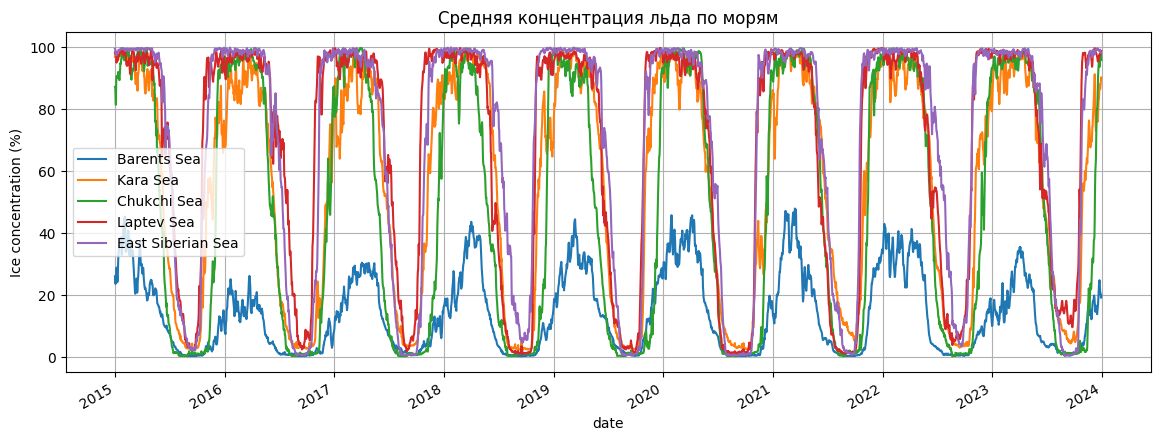

In [ ]:
# Визуализация всех регионов
df.plot(figsize=(14, 5), title="Средняя концентрация льда по морям")
plt.ylabel("Ice concentration (%)")
plt.grid(True)
plt.show()

In [ ]:
# Проверка стационарности и трендов

from statsmodels.tsa.stattools import adfuller

print("Результаты ADF-теста:")
for col in df.columns:
    series = df[col].dropna()
    result = adfuller(series)
    adf_stat, p_value = result[0], result[1]
    print(f"{col:25s} → ADF: {adf_stat:.2f}, p-value: {p_value:.4f} {'(стац.)' if p_value < 0.05 else '(нестац.)'}")

Результаты ADF-теста:
Barents Sea               → ADF: -4.75, p-value: 0.0001 (стац.)
Kara Sea                  → ADF: -5.10, p-value: 0.0000 (стац.)
Chukchi Sea               → ADF: -5.73, p-value: 0.0000 (стац.)
Laptev Sea                → ADF: -4.62, p-value: 0.0001 (стац.)
East Siberian Sea         → ADF: -5.71, p-value: 0.0000 (стац.)


<ipython-input-10-d7b652fc8e5b>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = df.resample("M").mean()


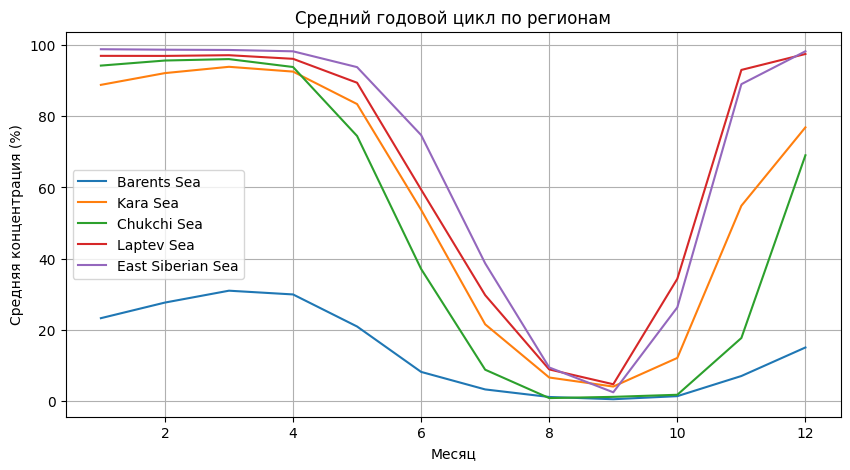

In [ ]:
# Группировка по месяцам
monthly = df.resample("M").mean()

# Средний годовой цикл
monthly["month"] = monthly.index.month
seasonal = monthly.groupby("month").mean()

seasonal.plot(figsize=(10, 5), title="Средний годовой цикл по регионам")
plt.xlabel("Месяц")
plt.ylabel("Средняя концентрация (%)")
plt.grid(True)
plt.show()

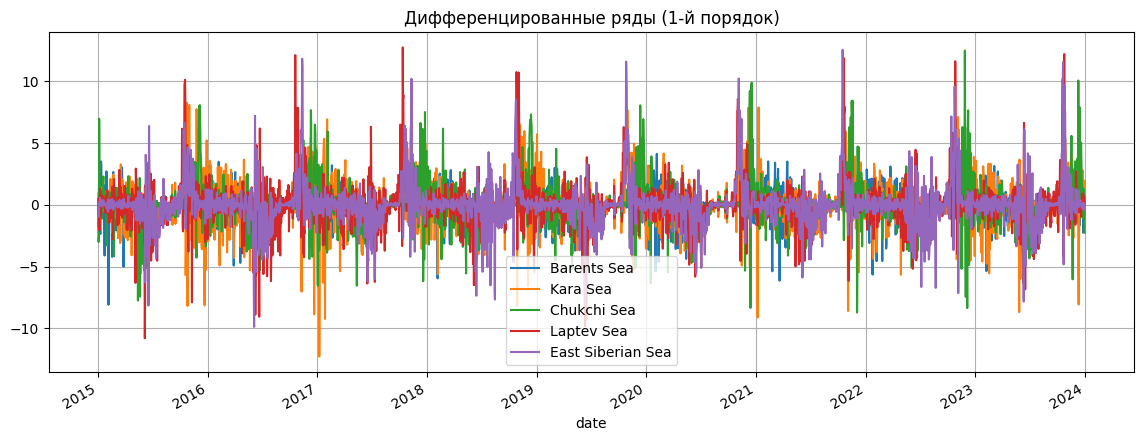

In [ ]:
# Дифференцированные ряды

df_diff = df.diff().dropna()
df_diff.plot(figsize=(14, 5), title="Дифференцированные ряды (1-й порядок)")
plt.grid(True)
plt.show()

In [ ]:
# Проверка стационарности и трендов

from statsmodels.tsa.stattools import adfuller

print("Результаты ADF-теста:")
for col in df.columns:
    series = df[col].dropna()
    result = adfuller(series)
    adf_stat, p_value = result[0], result[1]
    print(f"{col:25s} → ADF: {adf_stat:.2f}, p-value: {p_value:.4f} {'(стац.)' if p_value < 0.05 else '(нестац.)'}")

Результаты ADF-теста:
Barents Sea               → ADF: -4.75, p-value: 0.0001 (стац.)
Kara Sea                  → ADF: -5.10, p-value: 0.0000 (стац.)
Chukchi Sea               → ADF: -5.73, p-value: 0.0000 (стац.)
Laptev Sea                → ADF: -4.62, p-value: 0.0001 (стац.)
East Siberian Sea         → ADF: -5.71, p-value: 0.0000 (стац.)


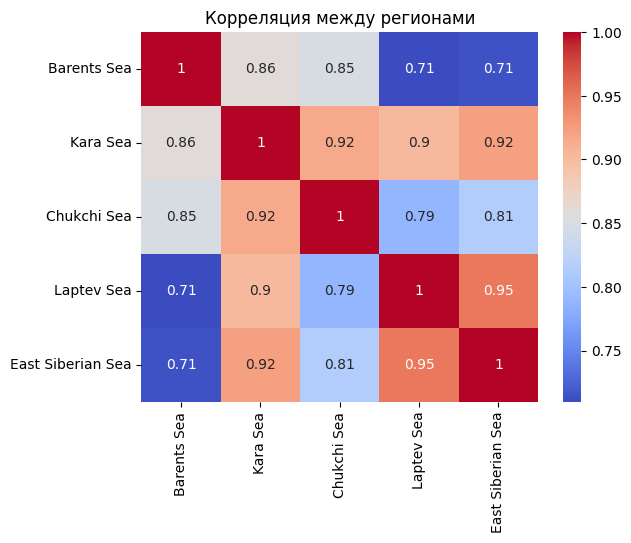

In [ ]:
# Корреляции между регионами

import seaborn as sns

sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title("Корреляция между регионами")
plt.show()

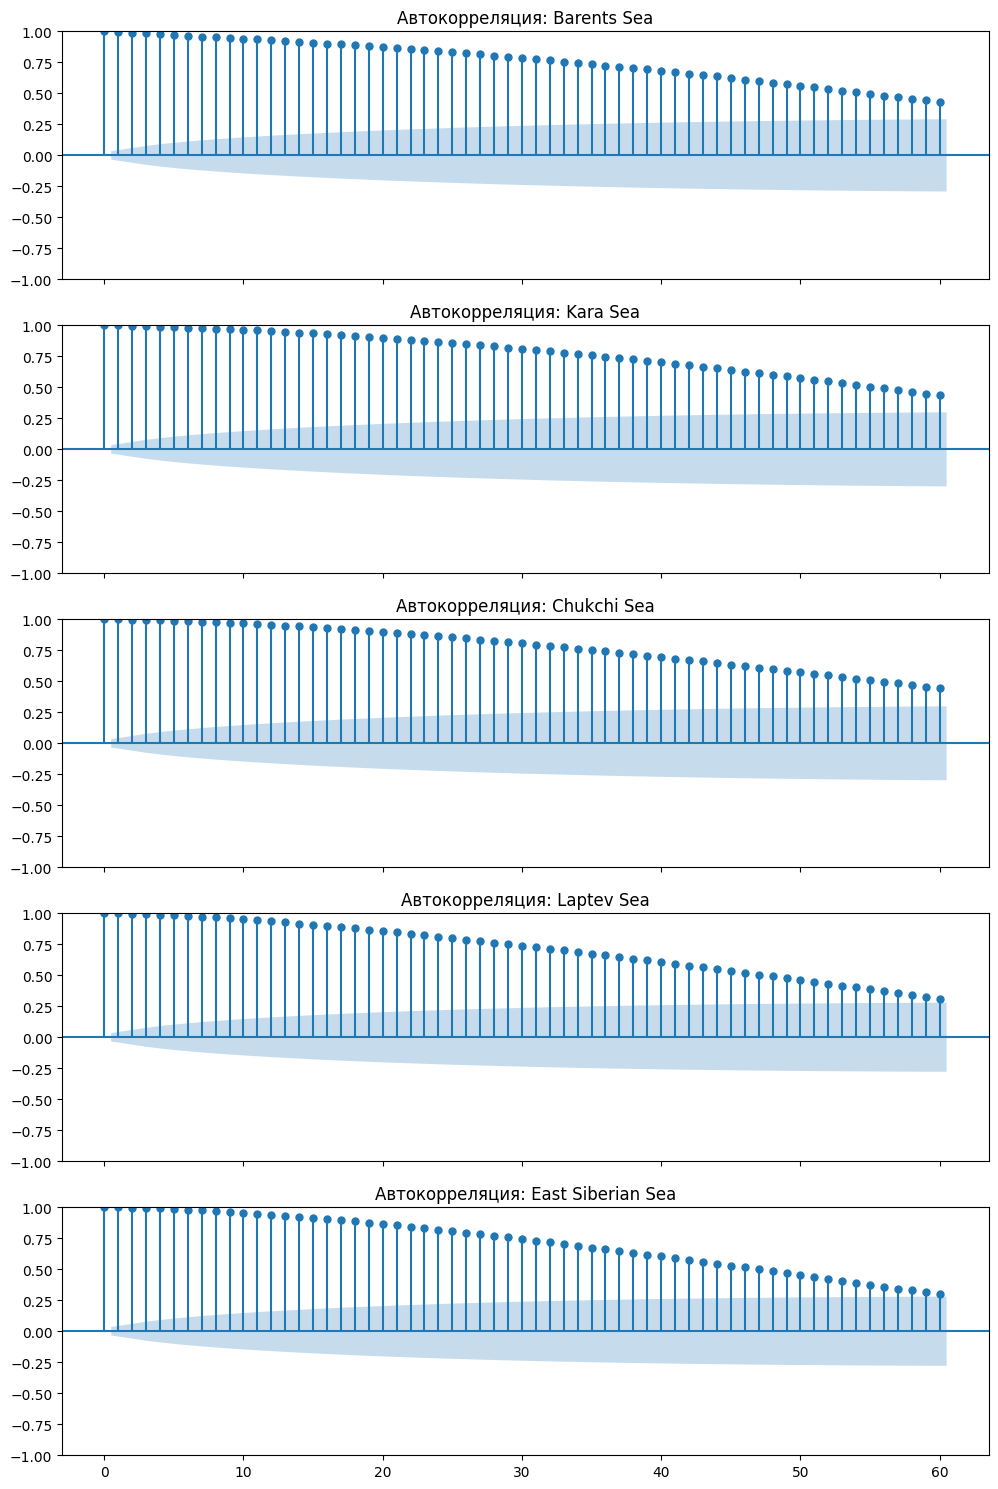

In [ ]:
# Автокорреляция и лаги

from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

regions = df.columns
n = len(regions)

fig, axes = plt.subplots(nrows=n, ncols=1, figsize=(10, 3 * n), sharex=True)

for i, region in enumerate(regions):
    series = df[region].dropna()
    plot_acf(series, lags=60, ax=axes[i])
    axes[i].set_title(f"Автокорреляция: {region}")

plt.tight_layout()
plt.show()

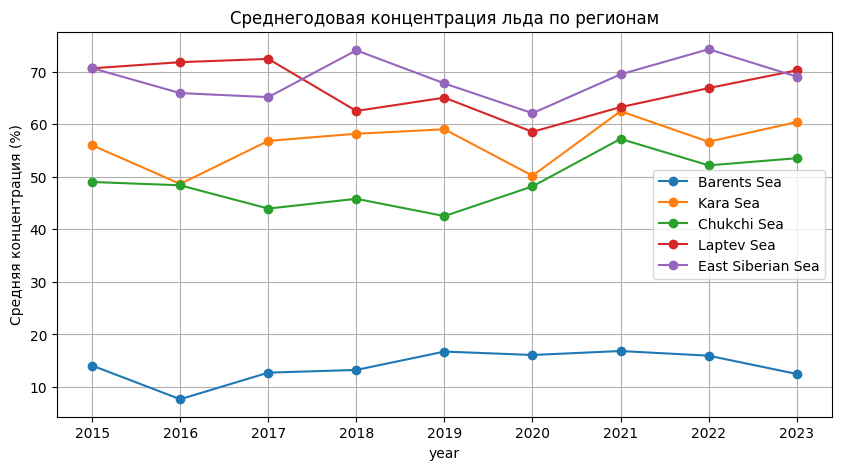

In [ ]:
# Усреднение по годам

df["year"] = df.index.year
yearly_mean = df.groupby("year").mean()
yearly_mean.plot(marker="o", figsize=(10, 5), title="Среднегодовая концентрация льда по регионам")
plt.ylabel("Средняя концентрация (%)")
plt.grid(True)
plt.show()

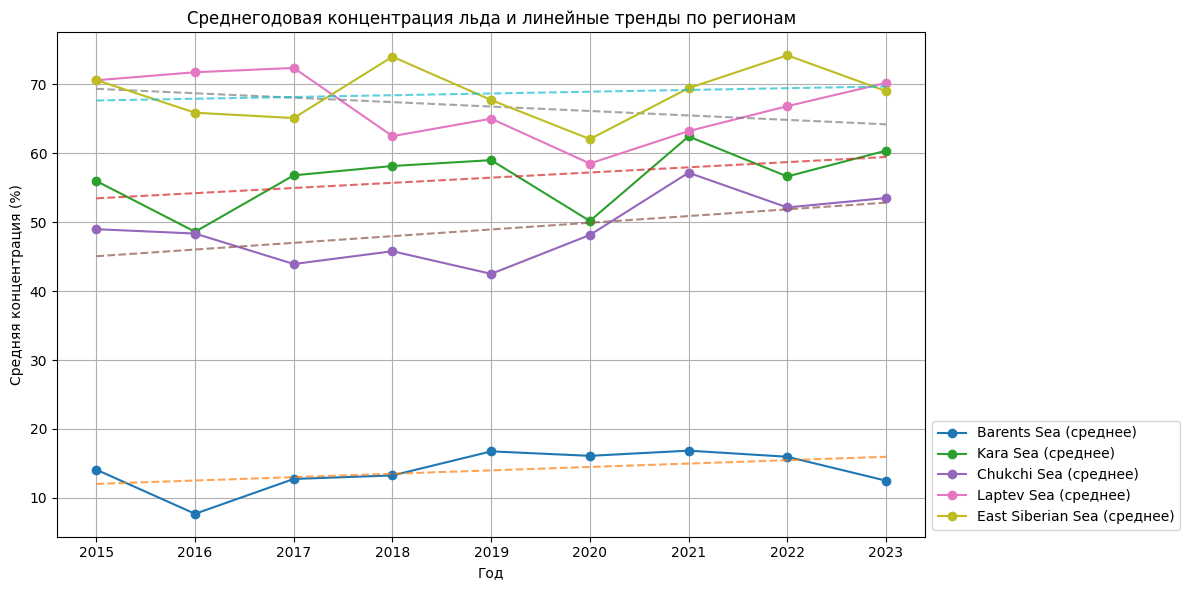

In [ ]:
# Линейный тренд по годам

import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

for col in yearly_mean.columns:
    # Среднегодовая линия
    plt.plot(yearly_mean.index, yearly_mean[col], marker="o", label=f"{col} (среднее)")

    # Линейный тренд
    z = np.polyfit(yearly_mean.index, yearly_mean[col], 1)
    p = np.poly1d(z)
    plt.plot(yearly_mean.index, p(yearly_mean.index), linestyle="--", alpha=0.7)

plt.title("Среднегодовая концентрация льда и линейные тренды по регионам")
plt.xlabel("Год")
plt.ylabel("Средняя концентрация (%)")
plt.grid(True)
plt.legend(loc="lower left", bbox_to_anchor=(1, 0))
plt.tight_layout()
plt.show()